# Customer Segmetation Based on Purchase

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
df = pd.read_csv('processed.csv', parse_dates=['InvoiceDate'])

* This is process data from original dataset which had every line item of the invoice as a row. We have combines every line Item and made a new column Subtotal.

## Data Exploration and Cleaning

In [3]:
df.head()

,InvoiceNo,InvoiceDate,CustomerID,Subtotal,Country
0,536365,2010-12-01 08:26:00,17850.0,139.12,United Kingdom
1,536366,2010-12-01 08:28:00,17850.0,22.20,United Kingdom
2,536367,2010-12-01 08:34:00,13047.0,278.73,United Kingdom
3,536368,2010-12-01 08:34:00,13047.0,70.05,United Kingdom
4,536369,2010-12-01 08:35:00,13047.0,17.85,United Kingdom


In [4]:
df.shape

(25900, 5)

In [5]:
df['CustomerID'].nunique()

4372

* We have 25900 invoices with 4372 unique customers

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25900 entries, 0 to 25899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    25900 non-null  object        
 1   InvoiceDate  25900 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  float64       
 3   Subtotal     25900 non-null  float64       
 4   Country      25900 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 1011.8+ KB


In [7]:
df.isna().sum()

InvoiceNo         0
InvoiceDate       0
CustomerID     3710
Subtotal          0
Country           0
dtype: int64

In [8]:
df = df[df['CustomerID'].notna()]

* Take only records which has a customer ID.

In [9]:
df.isna().sum()

InvoiceNo      0
InvoiceDate    0
CustomerID     0
Subtotal       0
Country        0
dtype: int64

In [10]:
df.shape

(22190, 5)

In [11]:
df['CustomerID'] = df['CustomerID'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22190 entries, 0 to 25899
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int32         
 3   Subtotal     22190 non-null  float64       
 4   Country      22190 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 953.5+ KB


* Converting customer ID to int from float.

In [12]:
df.describe()

,CustomerID,Subtotal
count,22190.000000,22190.000000
mean,15238.498738,374.045327
std,1733.149624,2018.482869
min,12346.000000,-168469.600000
25%,13755.000000,87.962500
50%,15136.000000,241.505000
75%,16746.000000,418.022500
max,18287.000000,168469.600000


* We have negative values in Subtotal column lets get rid of them.

In [13]:
df[df['Subtotal'] <=0 ].count()

InvoiceNo      3658
InvoiceDate    3658
CustomerID     3658
Subtotal       3658
Country        3658
dtype: int64

* We have 3658 records with Subtotal less than or equal to 0.

In [14]:
df = df[df['Subtotal'] > 0]

In [15]:
df.tail()

,InvoiceNo,InvoiceDate,CustomerID,Subtotal,Country
22056,581583,2011-12-09 12:23:00,13777,124.60,United Kingdom
22057,581584,2011-12-09 12:25:00,13777,140.64,United Kingdom
22058,581585,2011-12-09 12:31:00,15804,329.05,United Kingdom
22059,581586,2011-12-09 12:49:00,13113,339.20,United Kingdom
22060,581587,2011-12-09 12:50:00,12680,249.45,France


In [16]:
df.shape

(18532, 5)

* After removing we are left with 18532 records.

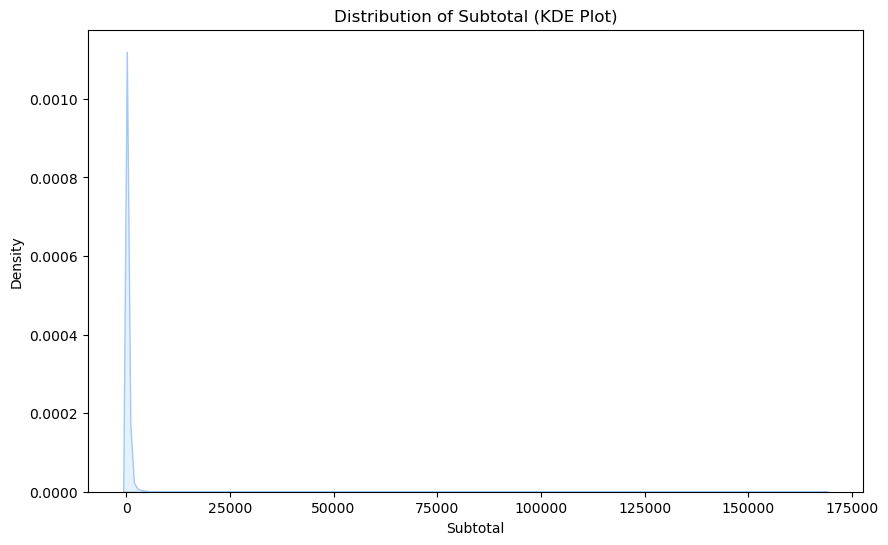

In [17]:
plt.figure(figsize=(10, 6))
sns.set_palette('pastel')
sns.kdeplot(data=df, x='Subtotal', fill=True)
plt.xlabel('Subtotal')
plt.ylabel('Density')
plt.title('Distribution of Subtotal (KDE Plot)')
plt.show()

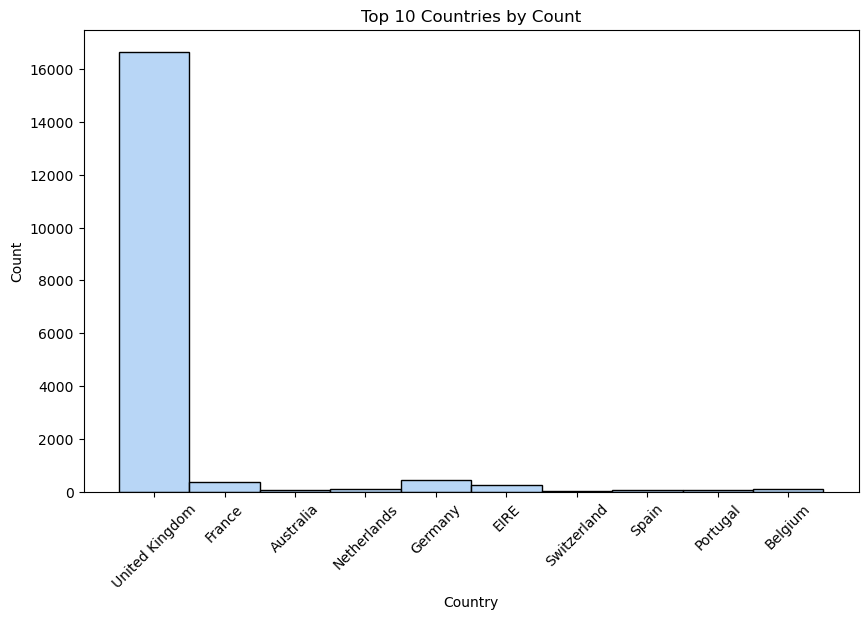

In [18]:
top_10_countries = df['Country'].value_counts().nlargest(10).index
df_top_10_countries = df[df['Country'].isin(top_10_countries)]
plt.figure(figsize=(10, 6))
sns.histplot(data=df_top_10_countries, x='Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Top 10 Countries by Count')
plt.xticks(rotation=45)
plt.show()

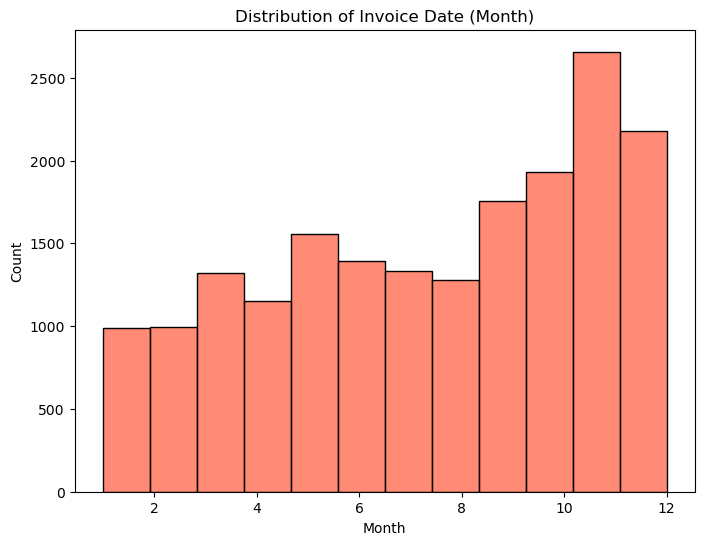

In [19]:
df['InvoiceMonth'] = df['InvoiceDate'].dt.month
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='InvoiceMonth', bins=12, kde=False, color='tomato', edgecolor='black')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Distribution of Invoice Date (Month)')
plt.show()

---

## Outlier Detection and Analysis

In [20]:
df['Subtotal'].describe([0.01, 0.10, 0.25, 0.50, 0.75, 0.9, 0.99])

count     18532.000000
mean        480.865956
std        1678.195579
min           0.380000
1%            8.500000
10%          85.866000
25%         158.037500
50%         303.040000
75%         471.840000
90%         824.788000
99%        3849.021400
max      168469.600000
Name: Subtotal, dtype: float64

* The 1% quantile to the 99% quantile spans a wide range, indicating the majority of data points are relatively close together. However, the presence of outliers is evident, with values beyond the 99% quantile, significantly extending the upper end of the distribution, as seen from the maximum value of 168,469.60

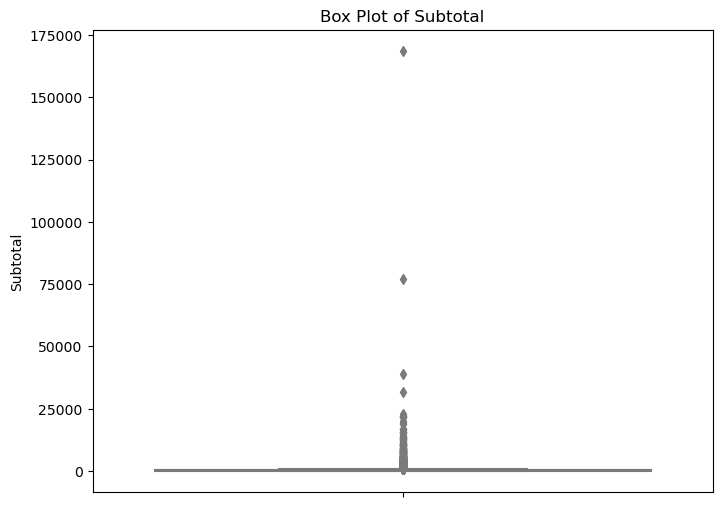

In [21]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='Subtotal')
plt.ylabel('Subtotal')
plt.title('Box Plot of Subtotal')
plt.show()

---

### Quantile-based Flooring and Capping

In [22]:
dfq = df.copy()
q1 = dfq['Subtotal'].quantile(0.01)
q99 = dfq['Subtotal'].quantile(0.9)
dfq['Subtotal'] = dfq['Subtotal'].clip(lower=q1, upper=q99)

In [23]:
dfq['Subtotal'].describe([0.01, 0.10, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99])

count    18532.000000
mean       345.707002
std        237.730423
min          8.500000
1%           8.500000
10%         85.866000
25%        158.037500
50%        303.040000
75%        471.840000
90%        824.750200
95%        824.788000
99%        824.788000
max        824.788000
Name: Subtotal, dtype: float64

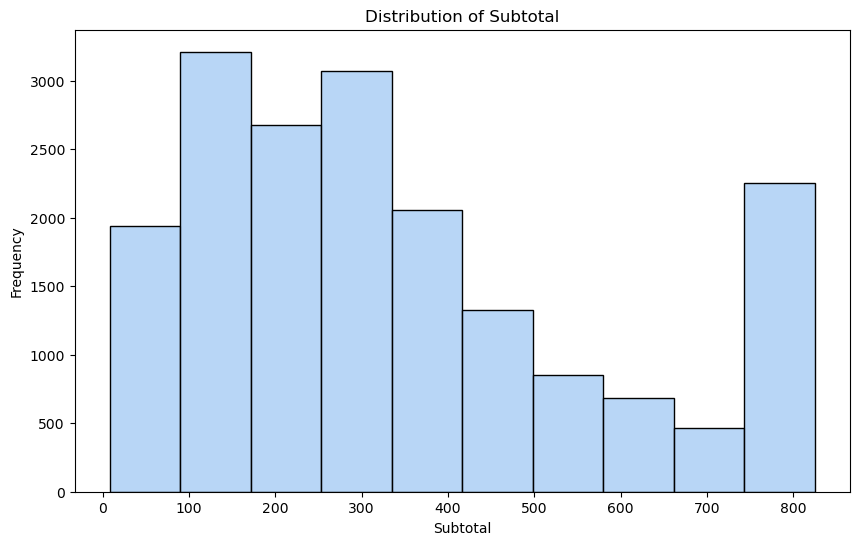

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dfq, x='Subtotal', bins=10, edgecolor='black')
plt.xlabel('Subtotal')
plt.ylabel('Frequency')
plt.title('Distribution of Subtotal')
plt.show()

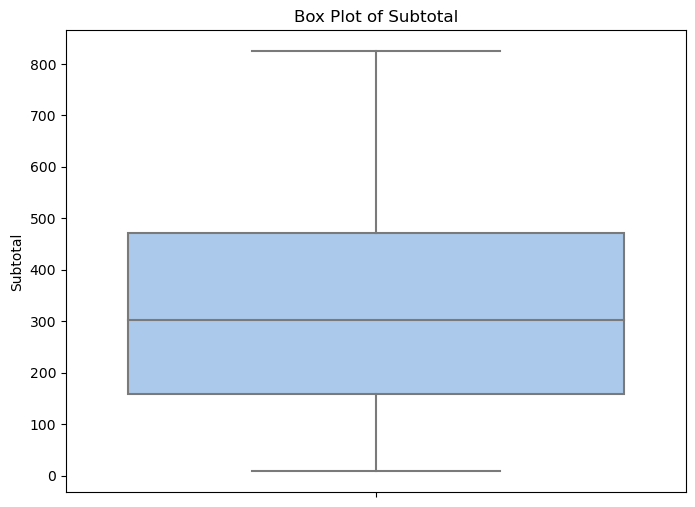

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=dfq, y='Subtotal')
plt.ylabel('Subtotal')
plt.title('Box Plot of Subtotal')
plt.show()

* I used quantile-based flooring and capping techniques using the 1st percentile as the floor and the 90th percentile as the cap. As a result, the dataset has been modified to ensure that extreme values beyond these percentiles are now restricted within a reasonable range, leading to a more robust and meaningful representation of the 'Subtotal' column

---

### Trimming

In [26]:
dft = df.copy()
lower_bound = 10
upper_bound = 900
dft = dft[(dft['Subtotal'] >= lower_bound) & (dft['Subtotal'] <= upper_bound)]

In [27]:
dft.shape

(16729, 6)

In [28]:
dft['Subtotal'].describe([0.01, 0.10, 0.25, 0.50, 0.75, 0.9, 0.99])

count    16729.000000
mean       305.686871
std        196.025934
min         10.000000
1%          15.300000
10%         88.500000
25%        152.250000
50%        284.680000
75%        408.000000
90%        596.984000
99%        850.488800
max        899.580000
Name: Subtotal, dtype: float64

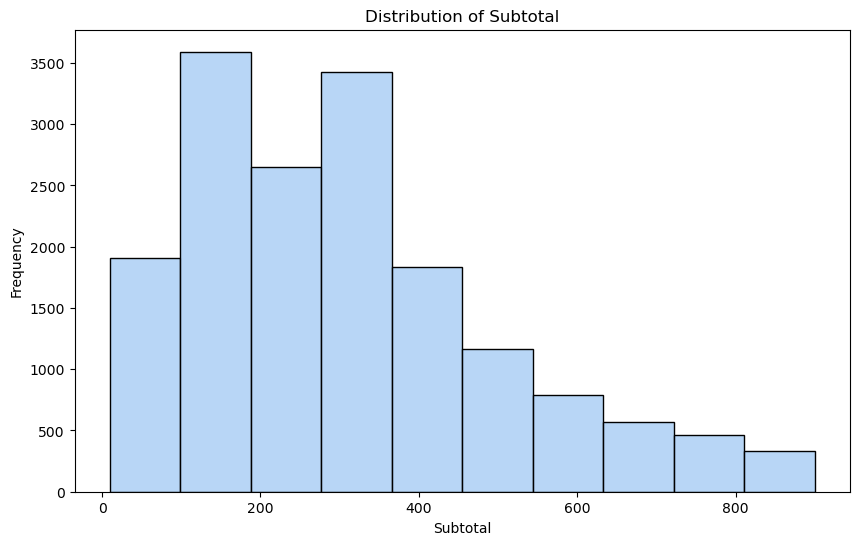

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dft, x='Subtotal', bins=10, edgecolor='black')
plt.xlabel('Subtotal')
plt.ylabel('Frequency')
plt.title('Distribution of Subtotal')
plt.show()

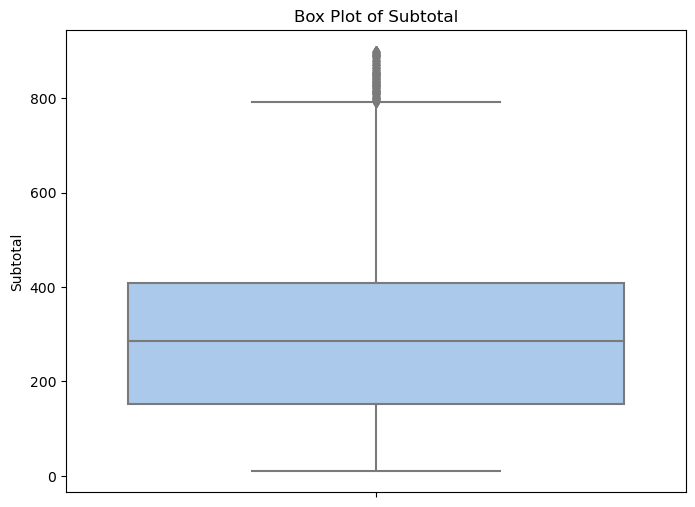

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=dft, y='Subtotal')
plt.ylabel('Subtotal')
plt.title('Box Plot of Subtotal')
plt.show()

* After experimenting with trimming the 'Subtotal' column using lower and upper bounds of 10 and 900, respectively, I found that some outliers persisted. Consequently, I've decided not to proceed with trimming as an outlier handling technique. Instead, I will be going ahead with Quantile-based Flooring and Capping.

---

### Log Transformation

In [31]:
dfl = df.copy()
dfl['Subtotal'] = np.log(dfl['Subtotal'])

In [32]:
dfl['Subtotal'].describe([0.01, 0.10, 0.25, 0.50, 0.75, 0.9, 0.99])

count    18532.000000
mean         5.583525
std          1.071720
min         -0.967584
1%           2.140066
10%          4.452788
25%          5.062832
50%          5.713865
75%          6.156640
90%          6.715126
99%          8.255574
max         12.034511
Name: Subtotal, dtype: float64

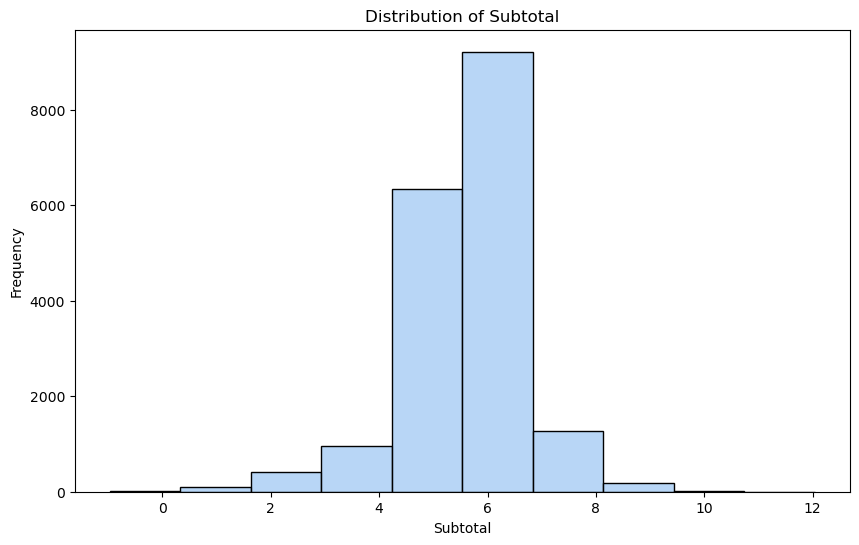

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(data=dfl, x='Subtotal', bins=10, edgecolor='black')
plt.xlabel('Subtotal')
plt.ylabel('Frequency')
plt.title('Distribution of Subtotal')
plt.show()

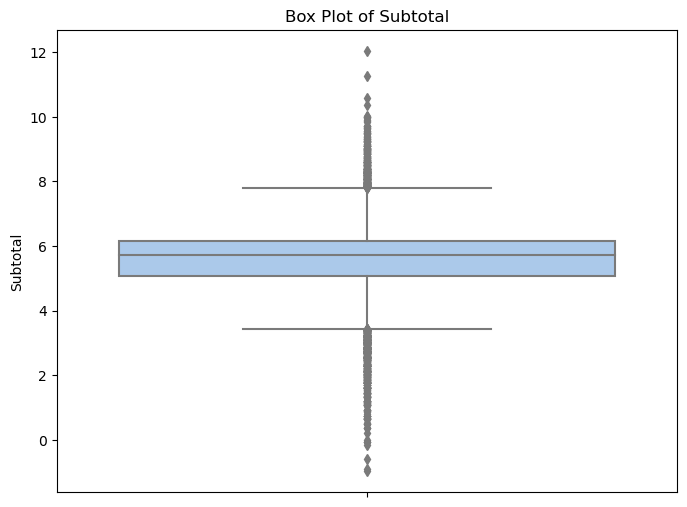

In [34]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=dfl, y='Subtotal')
plt.ylabel('Subtotal')
plt.title('Box Plot of Subtotal')
plt.show()

* Considering the need to retain the original scale for accurate calculations involving the 'Subtotal' values, I have decided not to proceed with log transformation. Instead, I will focus on employing quantile-based flooring and capping, where I used the 1st percentile as the floor and the 90th percentile as the cap. By doing so, I ensure that extreme values are constrained within a reasonable range, allowing me to maintain the data's integrity while performing meaningful calculations.

---

## Exploratory Data Analysis (EDA)

In [35]:
dft

,InvoiceNo,InvoiceDate,CustomerID,Subtotal,Country,InvoiceMonth
0,536365,2010-12-01 08:26:00,17850,139.12,United Kingdom,12
1,536366,2010-12-01 08:28:00,17850,22.20,United Kingdom,12
2,536367,2010-12-01 08:34:00,13047,278.73,United Kingdom,12
3,536368,2010-12-01 08:34:00,13047,70.05,United Kingdom,12
4,536369,2010-12-01 08:35:00,13047,17.85,United Kingdom,12
...,...,...,...,...,...,...
22056,581583,2011-12-09 12:23:00,13777,124.60,United Kingdom,12
22057,581584,2011-12-09 12:25:00,13777,140.64,United Kingdom,12
22058,581585,2011-12-09 12:31:00,15804,329.05,United Kingdom,12
22059,581586,2011-12-09 12:49:00,13113,339.20,United Kingdom,12


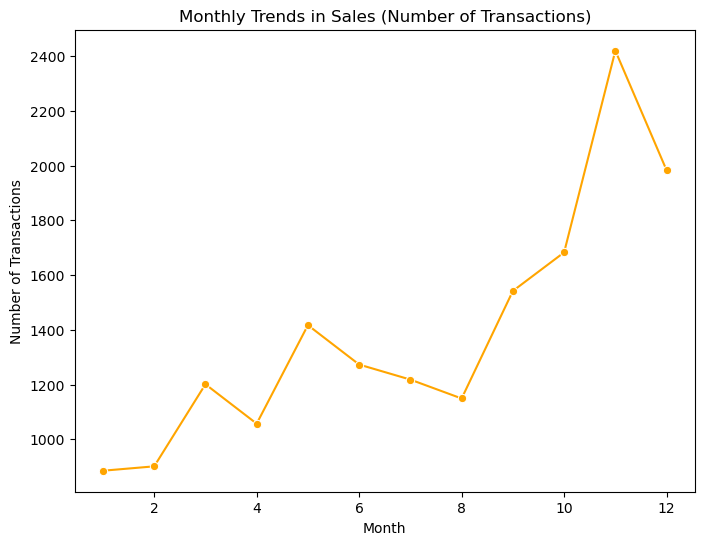

In [36]:
monthly_transactions = dft['InvoiceMonth'].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.lineplot(x=monthly_transactions.index, y=monthly_transactions.values, marker='o', color='orange')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Monthly Trends in Sales (Number of Transactions)')
plt.show()

---

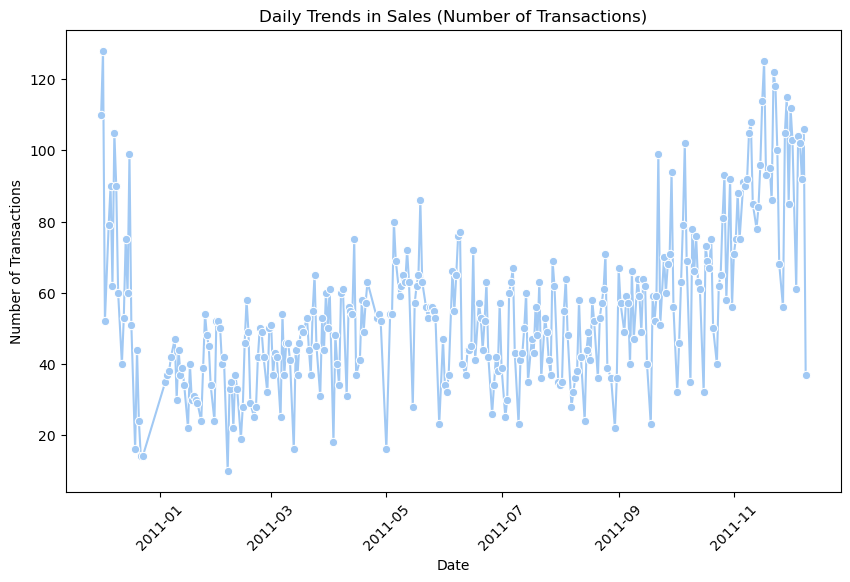

In [37]:
dft['InvoiceDate'] = pd.to_datetime(dft['InvoiceDate'])

# Extract the date part from 'InvoiceDate' for line plot
dft['InvoiceDate'] = dft['InvoiceDate'].dt.date

# Group the data by 'InvoiceDate' and count the number of transactions per day
daily_transactions = dft['InvoiceDate'].value_counts().sort_index()

# Plot the line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=daily_transactions.index, y=daily_transactions.values, marker='o')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Daily Trends in Sales (Number of Transactions)')
plt.xticks(rotation=45)
plt.show()

---

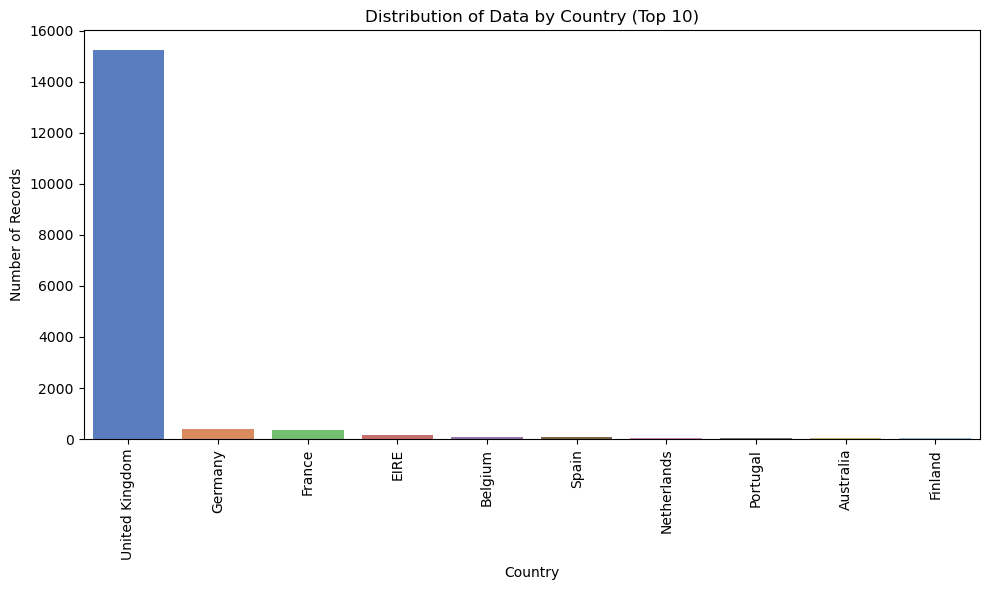

In [38]:
country_counts = dft['Country'].value_counts()
top_10_countries = country_counts.nlargest(10)

# Create a bar plot to show the number of records for each of the top 10 countries
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_countries.index, y=top_10_countries.values, palette='muted')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Country')
plt.ylabel('Number of Records')
plt.title('Distribution of Data by Country (Top 10)')
plt.tight_layout()
plt.show()

---

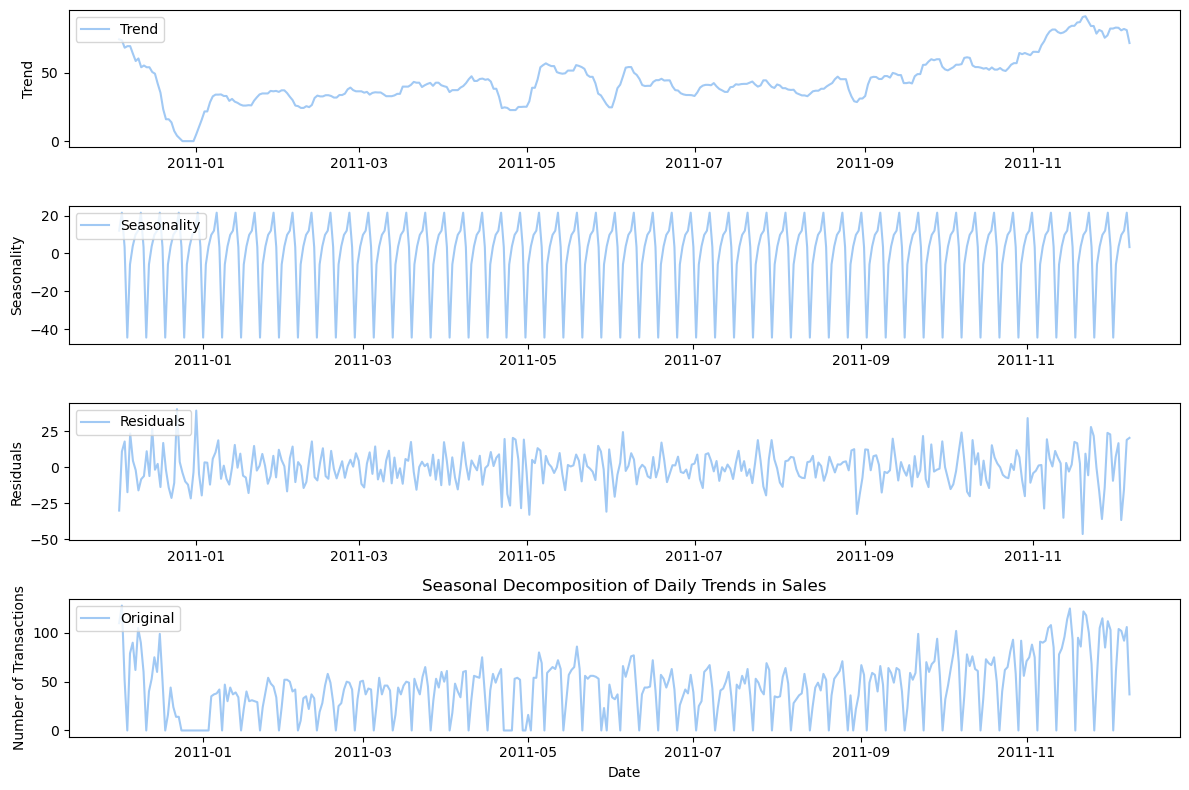

In [39]:
df_copy = dft.copy()
df_copy['InvoiceDate'] = pd.to_datetime(df_copy['InvoiceDate'])

df_copy.set_index('InvoiceDate', inplace=True)

daily_transactions = df_copy.resample('D')['InvoiceNo'].count()

# Perform seasonal decomposition
decomposition = seasonal_decompose(daily_transactions, model='additive')

# Plot the decomposition
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.ylabel('Trend')

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.ylabel('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='upper left')
plt.ylabel('Residuals')

plt.subplot(4, 1, 4)
plt.plot(daily_transactions, label='Original')
plt.legend(loc='upper left')
plt.ylabel('Number of Transactions')

plt.xlabel('Date')
plt.title('Seasonal Decomposition of Daily Trends in Sales')
plt.tight_layout()
plt.show()

---

In [40]:
customer_metrics = dft.groupby('CustomerID').agg(
    TotalSpent=('Subtotal', 'sum'),                  # Calculate total 'Subtotal' spent per customer
    AvgSpendingPerTransaction=('Subtotal', 'mean'),   # Calculate average spending per transaction
    FrequencyOfPurchases=('InvoiceNo', 'nunique')     # Calculate frequency of purchases (number of unique invoices)
)

In [41]:
top_spending_customers = customer_metrics.sort_values(by='FrequencyOfPurchases', ascending=False)
top_spending_customers.head()

,TotalSpent,AvgSpendingPerTransaction,FrequencyOfPurchases
CustomerID,,,
12748,26878.97,155.369769,173
14911,69965.13,469.564631,149
17841,39061.93,345.680796,113
14606,12152.98,132.097609,92
12971,11189.91,130.115233,86


In [42]:
def mark_purchase(grp_df):
    grp_df = grp_df.sort_values(by=['InvoiceDate'], ascending=[True])
    grp_df['PurchaseNumber'] = range(1, len(grp_df)+1)
    return grp_df
    

df_processed = dft.groupby('CustomerID').apply(mark_purchase).reset_index(drop=True)
df_processed

,InvoiceNo,InvoiceDate,CustomerID,Subtotal,Country,InvoiceMonth,PurchaseNumber
0,537626,2010-12-07,12347,711.79,Iceland,12,1
1,542237,2011-01-26,12347,475.39,Iceland,1,2
2,549222,2011-04-07,12347,636.25,Iceland,4,3
3,556201,2011-06-09,12347,382.52,Iceland,6,4
4,562032,2011-08-02,12347,584.91,Iceland,8,5
...,...,...,...,...,...,...,...
16724,578262,2011-11-23,18283,313.65,United Kingdom,11,12
16725,579673,2011-11-30,18283,223.61,United Kingdom,11,13
16726,580872,2011-12-06,18283,208.00,United Kingdom,12,14
16727,554065,2011-05-22,18287,765.28,United Kingdom,5,1


[4216, 2708, 1884, 1380, 1013, 787, 628, 504, 410, 348]


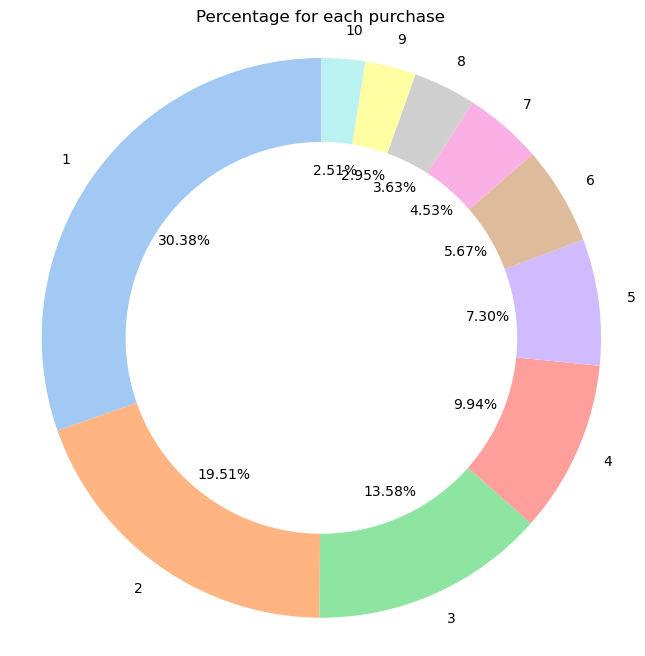

In [49]:
values = []
for i in range(1, 11):
    values.append(df_processed[df_processed['PurchaseNumber'] == i]['CustomerID'].count())

print(values)

# plt.title('Percentage for each purchase')
# plt.pie(values, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'] , autopct='%1.2f%%')

plt.figure(figsize=(8, 8))
outer_colors = sns.color_palette('pastel', len(values))
plt.pie(values, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], colors=outer_colors, autopct='%1.2f%%', startangle=90)

# Draw a white circle at the center to create the donut effect
center_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

plt.title('Percentage for each purchase')
plt.show()

---

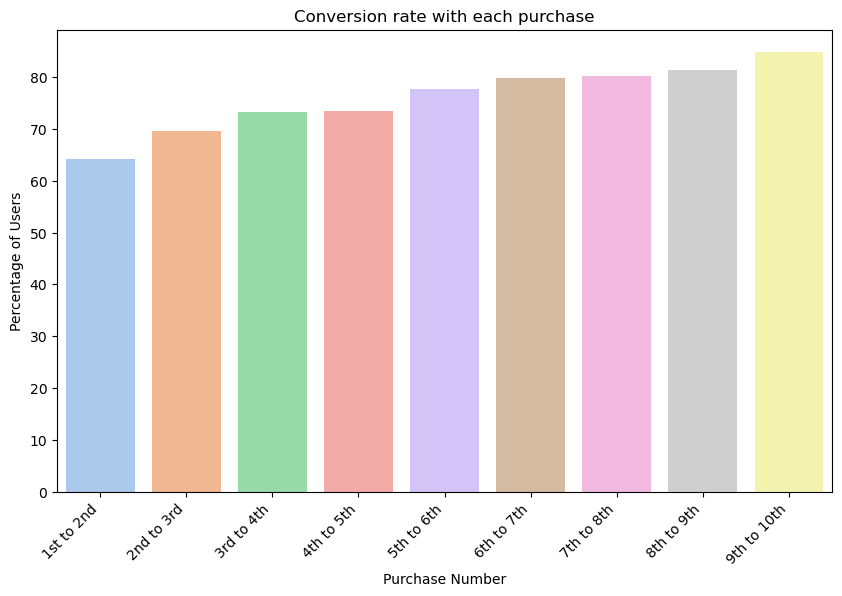

In [50]:
chunks = [values[i:i+2] for i in range(0, len(values), 1)]
conversions = []
# Print the chunks
for chunk in chunks:
    if len(chunk) > 1:
        conversions.append((chunk[1]/chunk[0])*100)
        
labels = ['1st to 2nd', '2nd to 3rd', '3rd to 4th', '4th to 5th', '5th to 6th', '6th to 7th', '7th to 8th', '8th to 9th', '9th to 10th']
 
# creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=conversions, palette='pastel')

# Rotate x-axis labels at 45 degrees
plt.xticks(rotation=45, ha='right')

# Set plot labels and title
plt.xlabel('Purchase Number')
plt.ylabel('Percentage of Users')
plt.title('Conversion rate with each purchase')

plt.show()

---

## Main KPI Analysis for Whole Data

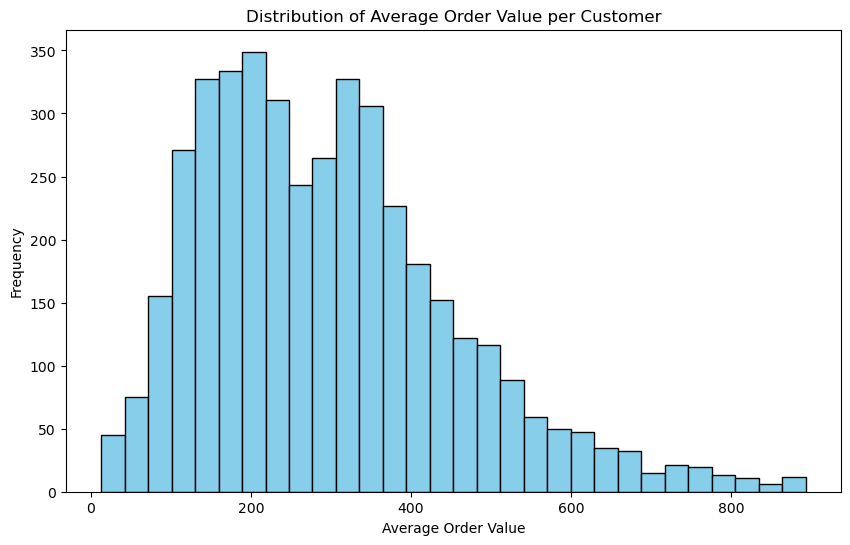

In [53]:
average_order_value = df_processed.groupby('CustomerID')['Subtotal'].mean()

plt.figure(figsize=(10, 6))
plt.hist(average_order_value, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Average Order Value')
plt.ylabel('Frequency')
plt.title('Distribution of Average Order Value per Customer')
plt.show()

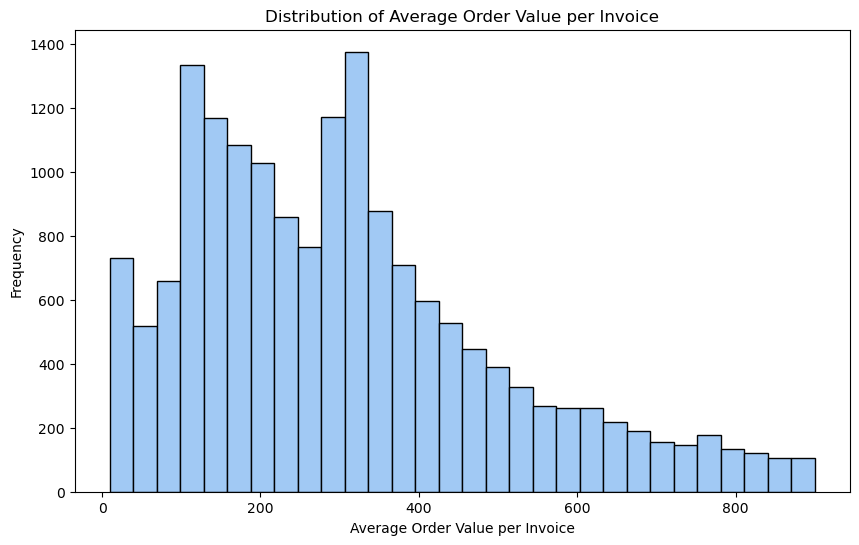

In [104]:
average_order_value_per_invoice = df_processed.groupby('InvoiceNo')['Subtotal'].mean()

# Create a histogram to visualize the distribution of average order values per invoice
plt.figure(figsize=(10, 6))
plt.hist(average_order_value_per_invoice, bins=30, edgecolor='black')
plt.xlabel('Average Order Value per Invoice')
plt.ylabel('Frequency')
plt.title('Distribution of Average Order Value per Invoice')
plt.show()

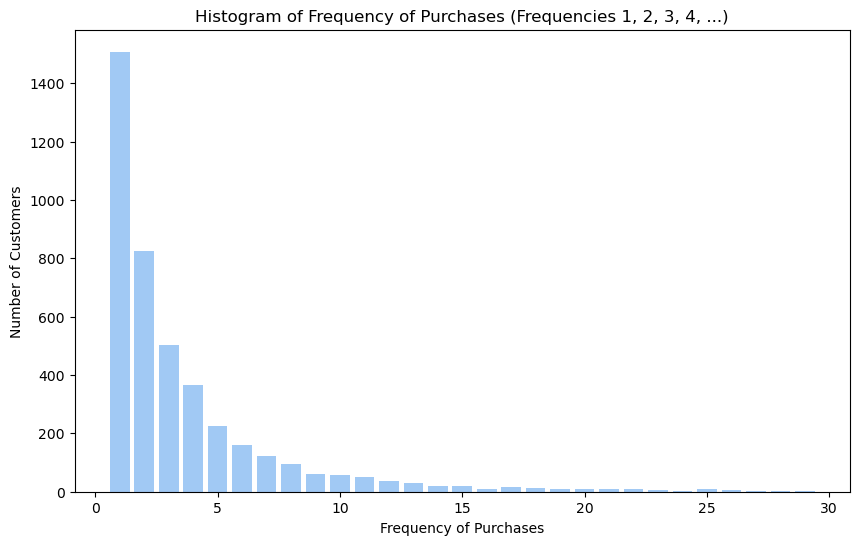

In [101]:
purchase_frequency = df_processed.groupby('CustomerID')['PurchaseNumber'].nunique()

# Filter the results to include only frequencies less than 30
purchase_frequency_less_than_30 = purchase_frequency[purchase_frequency < 30]

# Get the counts of each frequency
frequency_counts = purchase_frequency_less_than_30.value_counts().sort_index()

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(frequency_counts.index, frequency_counts.values)
plt.xlabel('Frequency of Purchases')
plt.ylabel('Number of Customers')
plt.title('Histogram of Frequency of Purchases')
plt.show()

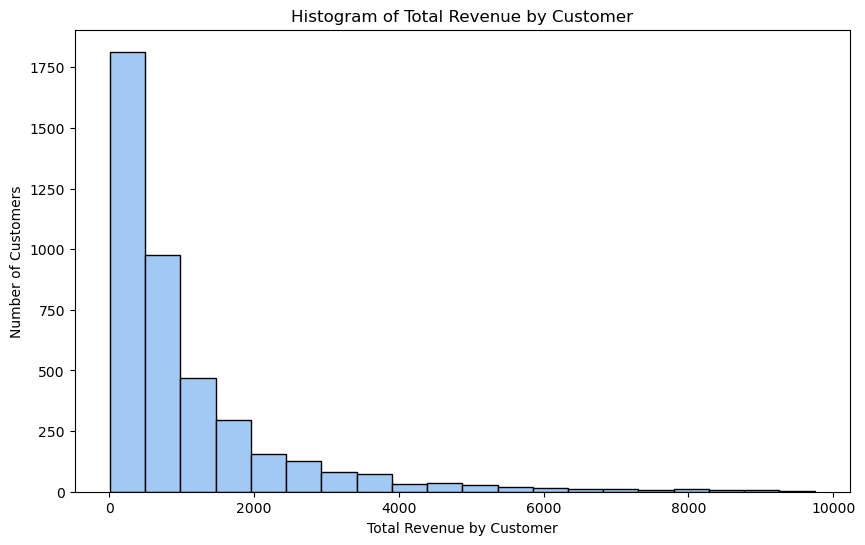

In [105]:
total_revenue_by_customer = df_processed.groupby('CustomerID')['Subtotal'].sum()

total_revenue_less_than_10000 = total_revenue_by_customer[total_revenue_by_customer < 10000]
# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(total_revenue_less_than_10000, bins=20, edgecolor='black')
plt.xlabel('Total Revenue by Customer')
plt.ylabel('Number of Customers')
plt.title('Histogram of Total Revenue by Customer')
plt.show()

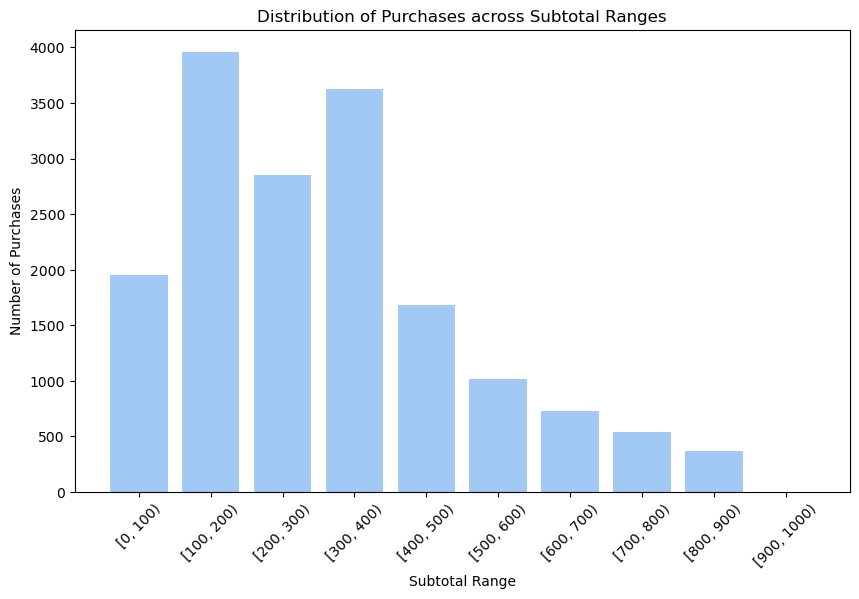

In [87]:
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]  # Customize the bins as needed

# Group the data by the subtotal ranges using the 'cut' function
subtotal_ranges = pd.cut(df_processed['Subtotal'], bins=bins, right=False)

# Count the number of purchases in each subtotal range
purchase_counts = subtotal_ranges.value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(purchase_counts.index.astype(str), purchase_counts.values)
plt.xlabel('Subtotal Range')
plt.ylabel('Number of Purchases')
plt.title('Distribution of Purchases across Subtotal Ranges')
plt.xticks(rotation=45)
plt.show()

---

## Business Usecase of segmentation

Segmenting users based on 'Subtotal' is a crucial aspect of our analysis, offering numerous business advantages in the e-commerce or retail sector. By grouping customers into distinct segments based on their spending behavior, we can uncover valuable insights that drive targeted strategies for enhanced customer engagement and retention. Personalized marketing initiatives can be devised, tailoring offers and recommendations to each segment, fostering customer loyalty and repeat purchases. Moreover, this segmentation empowers us to optimize pricing strategies, identify opportunities for upselling and cross-selling, and forecast demand for better inventory management. By leveraging user segmentation, we can implement effective retention tactics, provide premium support to high-value customers, and ultimately boost overall business performance by improving customer satisfaction and driving revenue growth.

## User Segmentation using K-Means

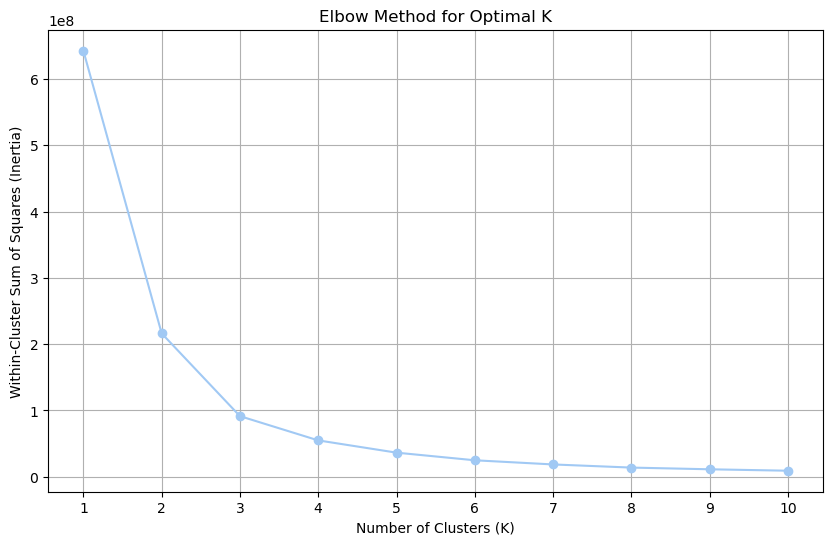

In [57]:
X = df_processed[['Subtotal']]

inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
b
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (Inertia)')
plt.title('Elbow Method for Optimal K')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

* The elbow method graph for 3 clusters shows a rapid decrease in inertia as the number of clusters increases. However, at K=3, the rate of decrease slows down, forming an "elbow" point. This suggests that 3 clusters strike a balance between improved clustering performance and simplicity, making it an optimal choice for the dataset.

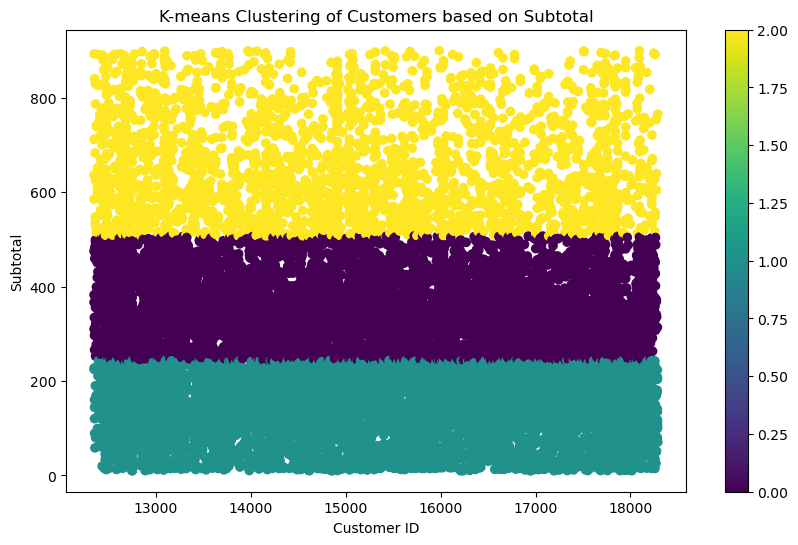

In [70]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = df_processed[['Subtotal']]

# Standardize the data to have mean=0 and variance=1 (important for K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# As we can see elbow point in above elbow method at 3 clusters so will be keeping 3 as the number of clusters
num_clusters = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_processed['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize the clustered data
plt.figure(figsize=(10, 6))
plt.scatter(df_processed['CustomerID'], df_processed['Subtotal'], c=df_processed['Cluster'], cmap='viridis')
plt.xlabel('Customer ID')
plt.ylabel('Subtotal')
plt.title('K-means Clustering of Customers based on Subtotal')
plt.colorbar()
plt.show()

## Analysis of each segment

In [107]:
df_processed

,InvoiceNo,InvoiceDate,CustomerID,Subtotal,Country,InvoiceMonth,PurchaseNumber,Cluster
0,537626,2010-12-07,12347,711.79,Iceland,12,1,2
1,542237,2011-01-26,12347,475.39,Iceland,1,2,0
2,549222,2011-04-07,12347,636.25,Iceland,4,3,2
3,556201,2011-06-09,12347,382.52,Iceland,6,4,0
4,562032,2011-08-02,12347,584.91,Iceland,8,5,2
...,...,...,...,...,...,...,...,...
16724,578262,2011-11-23,18283,313.65,United Kingdom,11,12,0
16725,579673,2011-11-30,18283,223.61,United Kingdom,11,13,1
16726,580872,2011-12-06,18283,208.00,United Kingdom,12,14,1
16727,554065,2011-05-22,18287,765.28,United Kingdom,5,1,2


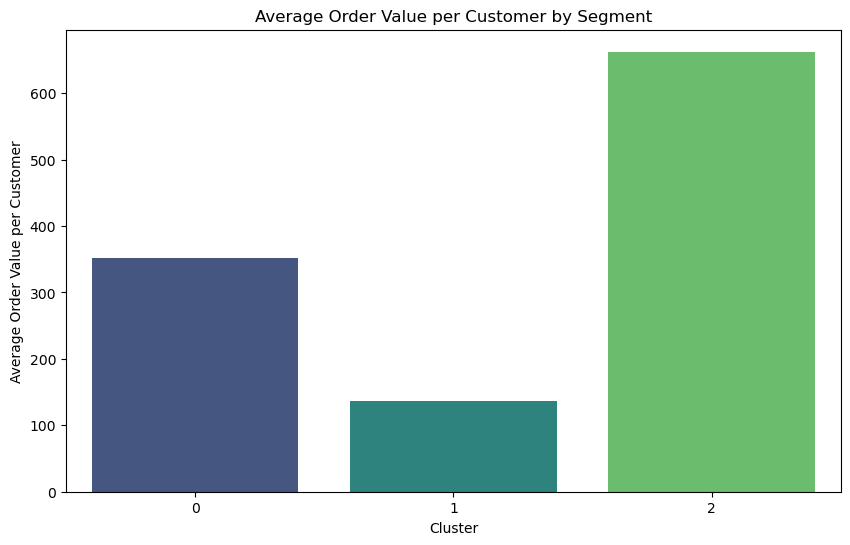

In [109]:
average_order_value_per_customer = df_processed.groupby('Cluster')['Subtotal'].mean()


plt.figure(figsize=(10, 6))
sns.barplot(x=average_order_value_per_customer.index, y=average_order_value_per_customer.values, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Average Order Value per Customer')
plt.title('Average Order Value per Customer by Segment')
plt.show()

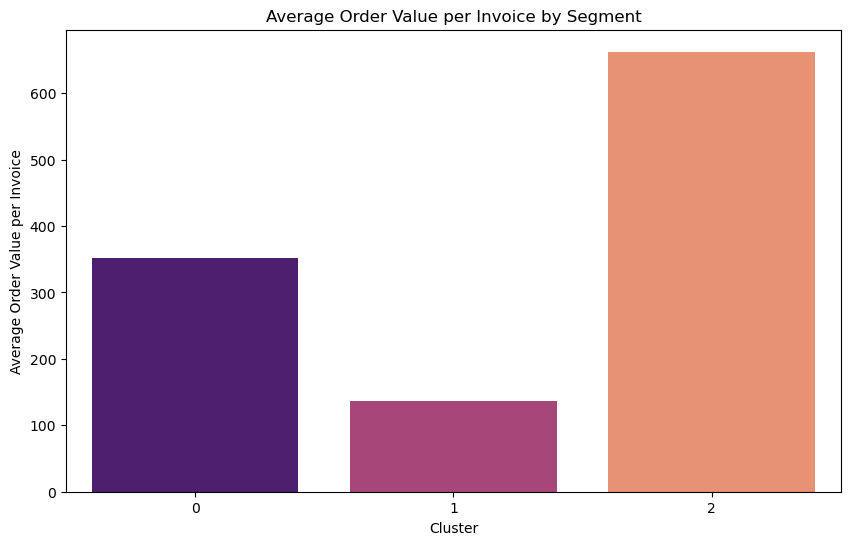

In [110]:
average_order_value_per_invoice = df_processed.groupby('Cluster').apply(lambda x: x['Subtotal'].sum() / x['InvoiceNo'].nunique())

plt.figure(figsize=(10, 6))
sns.barplot(x=average_order_value_per_invoice.index, y=average_order_value_per_invoice.values, palette='magma')
plt.xlabel('Cluster')
plt.ylabel('Average Order Value per Invoice')
plt.title('Average Order Value per Invoice by Segment')
plt.show()

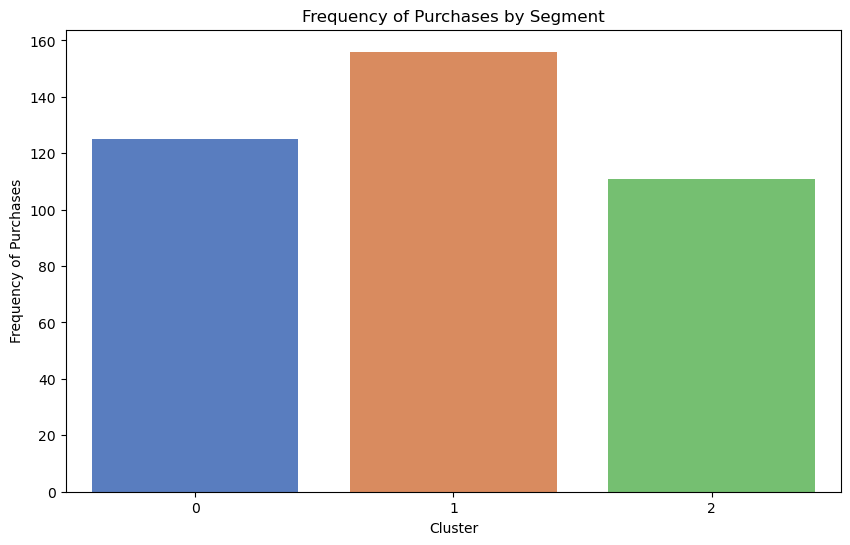

In [111]:
frequency_of_purchases = df_processed.groupby('Cluster')['PurchaseNumber'].nunique()

plt.figure(figsize=(10, 6))
sns.barplot(x=frequency_of_purchases.index, y=frequency_of_purchases.values, palette='muted')
plt.xlabel('Cluster')
plt.ylabel('Frequency of Purchases')
plt.title('Frequency of Purchases by Segment')
plt.show()

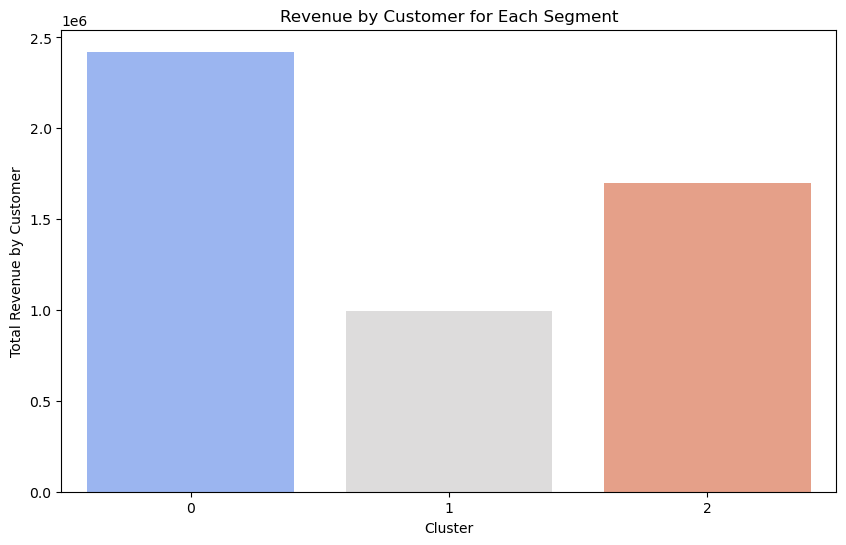

In [113]:
revenue_by_customer = df_processed.groupby('Cluster')['Subtotal'].sum()

plt.figure(figsize=(10, 6))
sns.barplot(x=revenue_by_customer.index, y=revenue_by_customer.values, palette='coolwarm')
plt.xlabel('Cluster')
plt.ylabel('Total Revenue by Customer')
plt.title('Revenue by Customer for Each Segment')
plt.show()

<Figure size 1200x600 with 0 Axes>

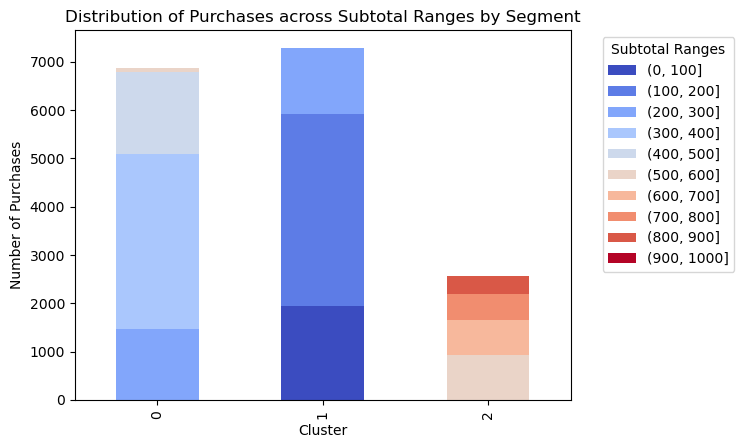

In [114]:
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Group the data by subtotal ranges and segment, and count the number of purchases in each range
purchases_by_subtotal_range = df_processed.groupby(['Cluster', pd.cut(df_processed['Subtotal'], bins=bins)])['InvoiceNo'].count().unstack()

plt.figure(figsize=(12, 6))
purchases_by_subtotal_range.plot(kind='bar', stacked=True, cmap='coolwarm')
plt.xlabel('Cluster')
plt.ylabel('Number of Purchases')
plt.title('Distribution of Purchases across Subtotal Ranges by Segment')
plt.legend(title='Subtotal Ranges', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()